In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import argparse
from glob import glob

rdir = 'results_final/'
frames = []
# load regression results
for f in glob(rdir + '*/*R.csv'):
        
    df = pd.read_csv(f,sep='\t',index_col=None)

#     print(f)
    if 'FeatJustCorr' in f:
        continue
    alg = df.algorithm.unique()
    if len(alg)>0:
        if 'XGB' in df['algorithm'][0]: 
            df['method'] = 'XGB'
        else:
            df['method'] = df['algorithm']
    df['median_score'] = df['score'].median()
    df['dataset'] = f.split('/')[-2]
    
    frames.append(df)
df_reg = pd.concat(frames)


print(len(df_reg), 'results')

print(df_reg.columns)
print(len(df_reg['dataset'].unique()),'datasets')
print('methods:',df_reg.method.unique())
print('unique seeds:',len(df_reg.seed.unique()))
print('dataset results',df_reg.groupby(['method']).count().reset_index())
# look at summaries
counts={}
methods = df_reg.method.unique()
for d,df_d in df_reg.groupby('dataset'):
    counts[d] = len(df_d['algorithm'].unique())
cool_ds = [d for d in counts.keys() if counts[d]>=len(methods)]
notcool_ds = [d for d in counts.keys() if counts[d]<len(methods)]
print(len(cool_ds),'cool ds')
# filter datasets without results
df_reg = df_reg.loc[df_reg['dataset'].isin(cool_ds)]
print('not cool ds:',notcool_ds)

print('methods:',df_reg.method.unique())
print('methods:',df_reg.algorithm.unique())
df_reg['score'] = df_reg['score'].astype(float)
df_reg['size'] = df_reg['size'].astype(float)

/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



4319 results
Index(['algorithm', 'cond', 'corr', 'dataset', 'median_score', 'method',
       'num_params', 'parameters', 'score', 'seed', 'size', 'time'],
      dtype='object')
117 datasets
methods: ['Feat' 'FeatCN' 'FeatCorr' 'KernelRidge' 'ElasticNet' 'MLP' 'RF' 'XGB']
unique seeds: 2681
dataset results         method  algorithm  cond  corr  dataset  median_score  num_params  \
0   ElasticNet        555   555   520      555           555         555   
1         Feat        551   551   535      551           551         551   
2       FeatCN        455   455   443      455           455         455   
3     FeatCorr        548   548   539      548           548         548   
4  KernelRidge        555   555   520      555           555         555   
5          MLP        530   530   502      530           530         530   
6           RF        585   585   585      585           585         585   
7          XGB        540   540   505      540           540         540   

   param

In [3]:
Order = ['Feat','FeatCorr','FeatCN','XGB','RF','MLP','KernelRidge','ElasticNet']

Index(['did', 'MajorityClassSize', 'MaxNominalAttDistinctValues',
       'MinorityClassSize', 'NumberOfClasses', 'NumberOfFeatures',
       'NumberOfInstances', 'NumberOfInstancesWithMissingValues',
       'NumberOfMissingValues', 'NumberOfNumericFeatures',
       'NumberOfSymbolicFeatures', 'name', 'status'],
      dtype='object')


<Figure size 432x288 with 0 Axes>

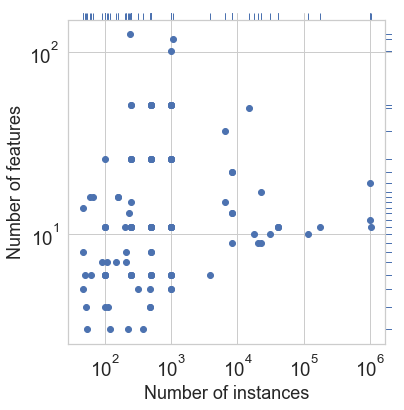

In [4]:
#plot of dataset properties
import matplotlib.pyplot as plt

df_data=pd.read_csv('Regression_datasets_pmlb.tsv', sep='\t')
print(df_data.columns)
cool_ids = [d.split('_')[0] for d in df_reg.dataset]
cool_ids = [d.split('_')[0] for d in cool_ds]

plt.figure()
sns.set(font_scale=1.7)
sns.set_style("whitegrid")
g=sns.JointGrid(x='NumberOfInstances',y='NumberOfFeatures', data=df_data,
               space=0,ratio=50)  
g.plot_joint(plt.scatter)
g.plot_marginals(sns.rugplot, height=1)
ax = g.ax_joint
ax.set_xlabel('Number of instances',size=18)
ax.set_ylabel('Number of features',size=18)
ax.set_xscale('log')
ax.set_yscale('log')
  

# plt.yticks(size=20)
plt.savefig('../paper/figs/pmlb.pdf')
sns.set(font_scale=1)


method median mean std
ElasticNet 0.27884370010282133 0.4000462053813265 0.3117646381176426
Feat 0.8734900137242021 0.7872507885991892 0.21640636097967184
FeatCN 0.8583461239407343 0.7748832611723256 0.22003548318725857
FeatCorr 0.8670322489984204 0.7716600575552457 0.41655369301436784
KernelRidge 0.6814832888527604 0.6163753671930706 0.27269178520889603
MLP 0.8224599875783041 0.712340572711366 0.2463267625731638
RF 0.802105710837151 0.7492235823950704 0.20654077725128608
XGB 0.8603812104810602 0.7991418588082894 0.17488337187209985


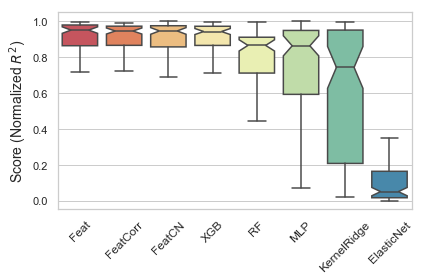

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.figure(figsize=(20,5))
df_reg['norm_score'] = df_reg.groupby('dataset')['score'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_sum=pd.DataFrame()#columns=['dataset','method','med_score'])
df_sum['med_score'] = df_reg.groupby(['dataset','method'])['score'].median().drop_duplicates()
df_sum['norm_score'] = df_reg.groupby(['dataset','method'])['norm_score'].median().drop_duplicates()

df_sum['count'] = df_reg.groupby(['dataset','method'])['score'].count()
df_sum=df_sum.reset_index(level=['dataset', 'method'])
sns.set_style('whitegrid')
sns.boxplot(data=df_sum,y='norm_score',x='method',notch=True,showfliers=False, 
             palette='Spectral',
            order=Order)

plt.xticks(rotation=45,size=12)
plt.ylabel('Score (Normalized $R^2$)',size=14)
plt.xlabel('')
plt.tight_layout()
plt.savefig('../paper/figs/boxplot_score.pdf')

print('method','median','mean','std')
for m,df in df_reg.groupby('method'):
    print(m,df['score'].median(),df['score'].mean(),df['score'].std())

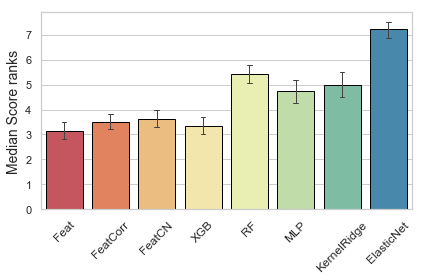

In [7]:
# ranks
import matplotlib.pyplot as plt
%matplotlib inline
df_ranks = pd.DataFrame(dtype=float)
df_ranks['median_scores'] = df_reg.groupby(['dataset','method'])['score'].median().drop_duplicates()

df_ranks= pd.DataFrame({"rank_r2": df_ranks.groupby('dataset')['median_scores'].rank(ascending=False)}
                      ).reset_index()

df_ranks.to_csv('r2_ranks.csv',index=False)
sns.barplot(data=df_ranks,y='rank_r2',x='method',edgecolor=(0,0,0),capsize=0.1,errwidth=1,
            fill=True,palette='Spectral',
            order=Order)
plt.xticks(rotation=45,size=12)
plt.ylabel('Median Score ranks',size=14)
plt.xlabel('')
plt.tight_layout()
plt.savefig('../paper/figs/barplot_ranks.pdf')

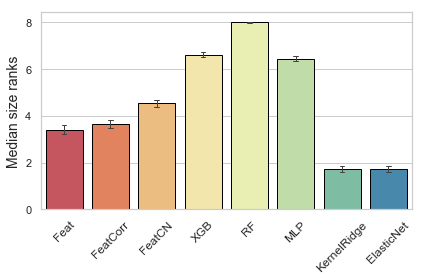

In [8]:
df_ranks = pd.DataFrame(dtype=float)
df_reg.loc[df_reg['method']=='MLP','size'] = df_reg.loc[df_reg['method']=='MLP']['num_params'] 
df_reg['size'] = df_reg['size'].apply(pd.to_numeric)
df_ranks['median_sizes'] = df_reg.groupby(['dataset','method'])['size'].median()
df_ranks= pd.DataFrame({"rank_size": df_ranks.groupby('dataset')['median_sizes'].rank(ascending=True)}
                      ).reset_index()
df_ranks.to_csv('size_ranks.csv',index=False)

sns.barplot(data=df_ranks,y='rank_size',x='method',edgecolor=(0,0,0),capsize=0.1,errwidth=1,
            fill=True,palette='Spectral',
            order=Order)
plt.xticks(rotation=45,size=12)
plt.ylabel('Median size ranks',size=14)
plt.xlabel('')
plt.tight_layout()
plt.savefig('../paper/figs/barplot_size_ranks.pdf')

8
6


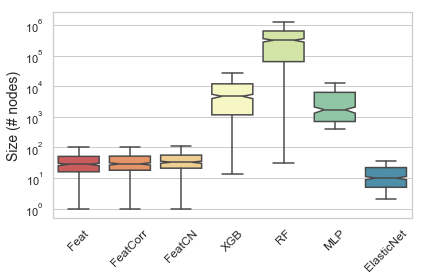

In [51]:
# import matplotlib.pyplot as plt
%matplotlib inline
pal = sns.color_palette('Spectral',n_colors=len(Order))
print(len(pal))

for i,o in reversed(list(enumerate(Order))):
    if o == 'KernelRidge':
        print(i)
        del pal[i]
df_reg.loc[df_reg['method']=='MLP','size'] = df_reg.loc[df_reg['method']=='MLP']['num_params'] 
df_reg['size'] = df_reg['size'].apply(pd.to_numeric)

sns.boxplot(data=df_reg,y='size',x='method',notch=True,showfliers=False,palette='Spectral',
            order=[o for o in Order if o != 'KernelRidge'])
plt.xticks(rotation=45,size=12)
plt.ylabel('Size (# nodes)',size=14)
plt.xlabel('')
plt.gca().set_yscale('log')

plt.tight_layout()
plt.savefig('../paper/figs/boxplot_size.pdf')

['axes.grid', 'axes.grid.axis', 'axes.grid.which', 'axes3d.grid', 'grid.alpha', 'grid.color', 'grid.linestyle', 'grid.linewidth', 'keymap.grid', 'keymap.grid_minor', 'polaraxes.grid']


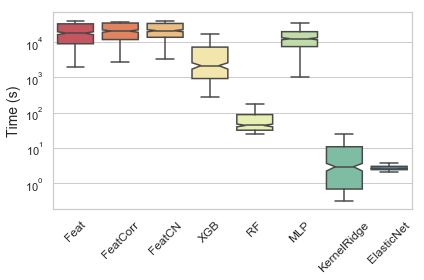

In [52]:
print([g for g in plt.rcParams.keys() if 'grid' in g])
sns.boxplot(data=df_reg,y='time',x='method',notch=True,showfliers=False, palette='Spectral',
            order=Order)
#             order=['','CN','Corr','SXO','CNSXO','CorrSXO'])
plt.ylabel('Time (s)',size=14)
plt.xticks(rotation=45,size=12)
plt.xlabel('')
plt.gca().set_yscale('log')

plt.tight_layout()
plt.savefig('../paper/figs/boxplot_time.pdf')

8
6
4
3


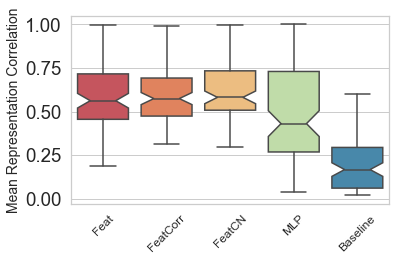

In [56]:
pal = sns.color_palette('Spectral',n_colors=len(Order))
print(len(pal))

for i,o in reversed(list(enumerate(Order))):
    if o not in ['Feat','FeatCorr','FeatCN','MLP','ElasticNet']:
        print(i)
        del pal[i]
        
df_reg['norm_corr'] = df_reg.groupby('dataset')['corr'].transform(lambda x: (x - x.min()) / (x.max() - x.min())).apply(lambda x: x if not np.isnan(x) else 1.0)
df_sum=pd.DataFrame()#columns=['dataset','method','med_score'])
df_sum['med_corr'] = df_reg.groupby(['dataset','method'])['corr'].median().drop_duplicates()
df_sum['norm_corr'] = df_reg.groupby(['dataset','method'])['norm_corr'].median().drop_duplicates()
df_sum=df_sum.reset_index(level=['dataset', 'method'])
# sns.set_palette(pal)
h = plt.figure()
df_sum.loc[df_sum.method=='ElasticNet','method'] = 'Baseline'
sns.set(font_scale=1.7)
sns.set_style('whitegrid')
sns.boxplot(data=df_sum,y='norm_corr',x='method',notch=True,showfliers=False,
        palette=sns.color_palette(pal), order=['Feat','FeatCorr','FeatCN','MLP','Baseline'])
#             ,order=[o for o in Order if o not in ['RF']])
#         order=['','SXO','CN','Corr','CNSXO','CorrSXO'])
# plt.title(d)
plt.ylabel('Mean Representation Correlation',size=14)
plt.xlabel('')
plt.xticks(rotation=45,size=12)
plt.tight_layout()
plt.savefig('../paper/figs/boxplot_corr.pdf')